In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Uncensored chicago data

After asking around the research community, it appears that the chicago dataset has been re-geocoded sometime in the last year (or so).  In the past, each event was geocoded to a fairly exact address (perhaps building entrance).

A little searching can find copies of extracts of this data.  As there must have been a good reason for changing the geocoding (presumably privacy based) we will not release a copy of this data, and we will be careful when drawing maps etc. not to show more detail than can already by found in the literature.

However, it is interesting to compare the data, and gain some insight into how the new geocoding is performed.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import numpy as np

import open_cp.sources.chicago as chicago
import os, lzma

filename = os.path.join("..", "..", "..", "..", "Data", "two.csv")
file_all = os.path.join("..", "..", "open_cp", "sources", "chicago_all.csv.xz")

## Load the uncensored data

- As usual, we'll drop the "HOMICIDE" crimes.  
- The case number "HV612588" is reported twice, and one looks like an error.  We'll drop in

In [3]:
# Load the uncensored data
data = chicago.load_to_geoDataFrame(filename, type="all_other")
data = data[data.case != "HV612588"]
data = data[data.crime != "HOMICIDE"]
len(data)

867201

In [4]:
# So every row has a unique case
assert len(data.case.unique()) == len(data)

In [5]:
data = data.set_index("case")

## Load matching "new" data

We load the same case numbers from the dataset (downloaded in May 2017), perform a little manual cleaning, and check that we then have a unique set of case numbers.

We are now mising about 1000 cases from the "old" data.

In [6]:
cases = set(data.index)

with lzma.open(file_all, "rt") as file:
    data_all = [event for event in chicago.generate_GeoJSON_Features(file, type="all")
               if event["properties"]["case"] in cases]
data_all = gpd.GeoDataFrame.from_features(data_all)

In [7]:
len(data_all), len(data_all.case.unique())

(866222, 866218)

In [8]:
data_all = data_all[(data_all.case != "") |
     ((data_all.case == "") & (data_all.crime == "BURGLARY"))]
data_all = data_all[(data_all.case != "HT155546") |
    ((data_all.case == "HT155546") & (data_all.location == "TAVERN/LIQUOR STORE"))]

In [9]:
len(data_all), len(data_all.case.unique())

(866218, 866218)

In [10]:
data_all = data_all.set_index("case")

In [11]:
len(set(data.index) - set(data_all.index)), len(set(data_all.index) - set(data.index))

(983, 0)

## Check the time range

We now look at the current file, and find all events in the same time range.  There are about 1000 more; so very good agreement overall.

In [12]:
times = data.timestamp.map(chicago._date_from_iso)
start, end = min(times), max(times)
start, end

(Timestamp('2010-09-13 14:15:00'), Timestamp('2013-04-16 05:00:00'))

In [13]:
with lzma.open(file_all, "rt") as file:
    data_all_in_time = []
    for event in chicago.generate_GeoJSON_Features(file, type="all"):
        ts = chicago._date_from_iso(event["properties"]["timestamp"])
        if ts >= start and ts <= end:
            data_all_in_time.append(event)
data_all_in_time = gpd.GeoDataFrame.from_features(data_all_in_time)

In [14]:
len(set(data_all_in_time.case))

877010

In [15]:
data_all_in_time = None

# Check for any differences, except in geometry

Turns out there are quite a few differences.

- A _lot_ of differences in "crime", and a huge number in "type".  I have not looked closely, but from a brief look, it seems that the differences are mostly down to reasonable re-classification.

In [16]:
both = pd.merge(data, data_all, left_index=True, right_index=True)

In [17]:
print("'address' differences", len(both[~(both.address_x == both.address_y)]))
print("'crime' differences", len(both[~(both.crime_x == both.crime_y)]))
print("'type' differences", len(both[~(both.type_x == both.type_y)]))
print("'location' differences", len(both[~(both.location_x == both.location_y)]))
print("'timestamp' differences", len(both[~(both.timestamp_x == both.timestamp_y)]))

'address' differences 84
'crime' differences 5296
'type' differences 20815
'location' differences 80
'timestamp' differences 5087


# Compute difference in distance between the points

In lon/lat space, which is areal, but not unreasonable on a small scale like this.

We then visualise, with a log scale.  So almost all points are between 10e-3 and 10e-4 distance apart.  I.e. most move a bit, but not too much.

In [18]:
dists = []
for _, row in both.iterrows():
    if row.geometry_x is not None and row.geometry_y is not None:
        dists.append(row.geometry_x.distance(row.geometry_y))
    else:
        dists.append(-1)
both["distance"] = dists

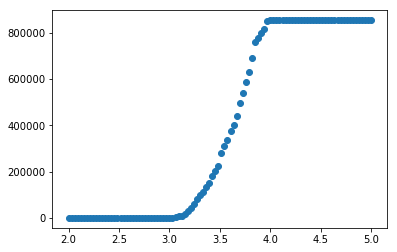

In [19]:
x = np.linspace(2, 5, 100)
xx = np.exp(-x * np.log(10)) 

y = [len(both[both["distance"] > t]) for t in xx]
fig, ax = plt.subplots()
ax.scatter(x,y)

## Assemble the points into a geoDataFrame

In [20]:
tmp = both.ix[both[both["distance"] < 0.001].index]
compare = gpd.GeoDataFrame()
compare["geo1"] = tmp["geometry_x"]
compare["geo2"] = tmp["geometry_y"]
compare["name1"] = tmp["address_x"]
compare["name2"] = tmp["address_y"]
compare.set_index(tmp.index)
tmp = None

compare = compare[compare.geo1.map(lambda pt : pt is not None)]
compare = compare[compare.geo2.map(lambda pt : pt is not None)]

In [21]:
import shapely.geometry

compare["geometry"] = [ shapely.geometry.LineString([ row.geo1, row.geo2 ])
    for _, row in compare.iterrows() ]

In [22]:
compare = compare.set_geometry("geometry")
compare.crs = {"init": "epsg:4326"}

In [35]:
import os
tmp = compare.drop(["geo1", "geo2"], axis=1)
tmp.to_file( os.path.join("..", "..", "..", "..", "Data", "Old_Chicago_SHP") )
tmp = None

In [24]:
bds = compare.total_bounds

In [25]:
lines = []
for geo in compare.geometry:
    xs, ys = geo.xy
    lines.append(list(zip(xs, ys)))

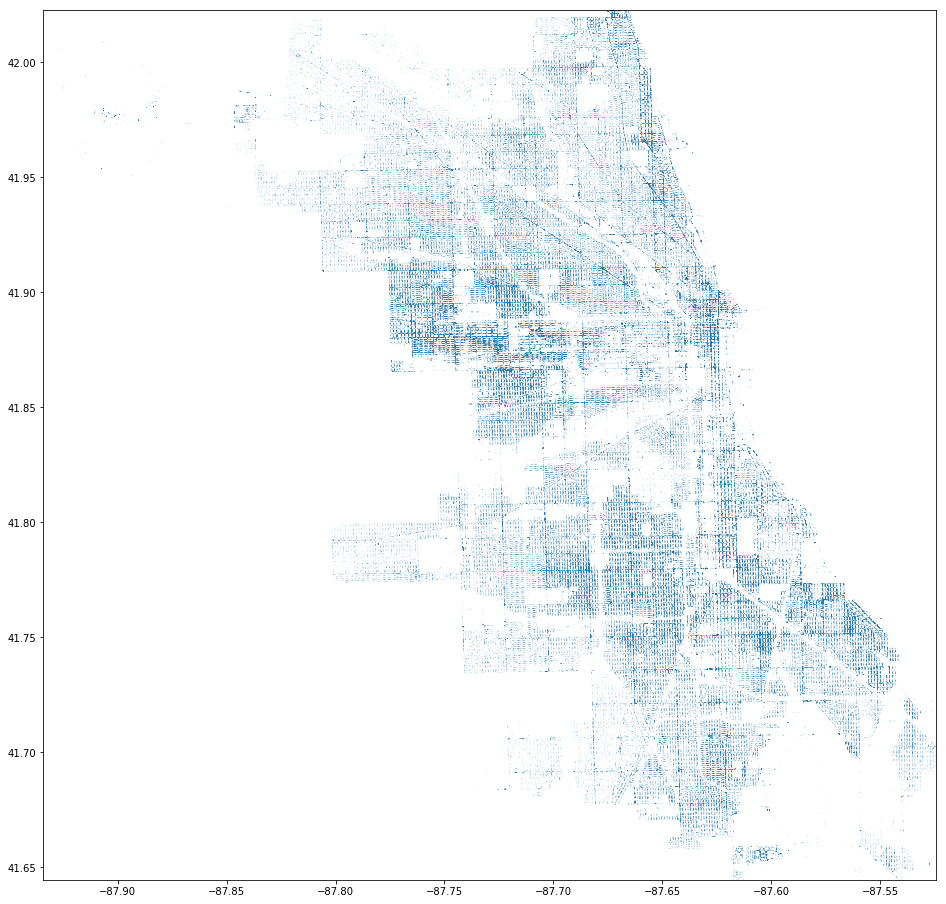

In [26]:
from matplotlib.collections import LineCollection
lc = LineCollection(lines, linewidths=0.1)

fig, ax = plt.subplots(figsize=(16,16))
ax.add_collection(lc)
ax.set(xlim=[bds[0], bds[2]], ylim=[bds[1], bds[3]])
None

# Look at one block

We'll pick some blocks at random (without giving their names, to protect privacy) and plot the difference in the geocoding as lines joining the old and new points.

What we see is that:
- Each point appears to be projected (orthogonally) to a line.  (Later we'll see that this line comes from the TIGER/Line dataset from the US Census bureau.)
- Then the points are squashed together.
- This has the effect of preserving the ordering and relative position along the block
- As you can see the last two plots, a single block might be split into more than one "edge", and this procedure appears to be applied to each "edge" independently.

We hence very clearly see how the pattern observed in the new/current dataset is generated: we will naturally end up with clumps of points in, roughly, the middle of the centre of the road of each block.

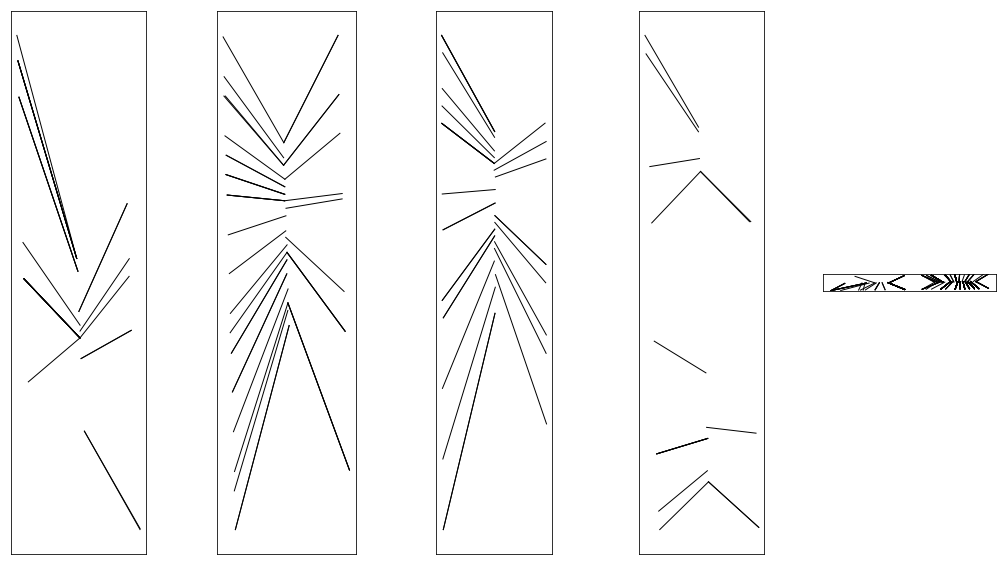

In [58]:
fig, axes = plt.subplots(ncols=5, figsize=(18,10))

blocks = np.random.randint(low=0, high=10000, size=5)
blocks = [3243, 7016, 6951, 5475,  804]
for i, ax in zip(blocks, axes):
    block = compare.ix[i].name1
    compare[compare.name1 == block].plot(ax=ax, color="black")
    ax.set_aspect(1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

## Look at the TIGER data

The [TIGER/Line](https://www.census.gov/geo/maps-data/data/tiger-line.html) dataset from the US Census bureau provides a great resource for getting block-level address data.  See the other notebook for more details.

In [59]:
filename = os.path.join("/media", "disk", "TIGER Data", "tl_2013_17031_edges", "tl_2013_17031_edges.shp")
edges = gpd.read_file(filename)

In [61]:
want = {"geometry", "FULLNAME", "LFROMADD", "LTOADD", "RFROMADD", "RTOADD"}
edges = gpd.GeoDataFrame({key:edges[key] for key in want})
edges.crs={'init': 'epsg:4269'}

In [62]:
import rtree

gap = 0.001

def gen():
    for i, row in edges.iterrows():
        bds = list(row.geometry.bounds)
        bds = [bds[0]-gap, bds[1]-gap, bds[2]+gap, bds[3]+gap]
        yield i, bds, None
        
idx = rtree.index.Index(gen())

In [63]:
def find_match_via_rtree(point):
    possibles = edges.ix[list(idx.intersection(point.coords[0]))]
    if len(possibles) == 0:
        #raise ValueError("Found no candidates for {}".format(point))
        from collections import namedtuple
        Error = namedtuple("Error", ["name"])
        return Error(name=-1)
    i = possibles.geometry.distance(point).argmin()
    return edges.ix[i]

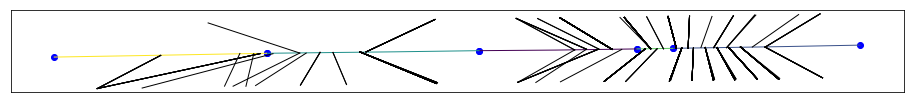

In [105]:
block = compare.ix[804].name1
block = compare[compare.name1 == block]
rows = set( find_match_via_rtree(row.geometry).name for _, row in block.iterrows() )
rows = edges.ix[rows]
rows = rows[~rows.FULLNAME.map(lambda x : x is None or x == "Alley")]

fig, ax = plt.subplots(figsize=(16,10))
rows.plot(ax=ax)
block.plot(color="black", ax=ax)

xcs, ycs = [], []
for geo in rows.geometry:
    x, y = geo.coords[0]
    xcs.append(x)
    ycs.append(y)
    x, y = geo.coords[-1]
    xcs.append(x)
    ycs.append(y)
ax.scatter(xcs, ycs, color="blue", marker="o")
ax.set_aspect(1)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

I have plotted here:

- Edge distinct edge from the TIGER dataset, in a different color.
- The start and end node of each edge, for easier visualistion.

What I see here is no particularly clear pattern.

- Visually, if we ignore the edge plot, then there seem to be two distinct "blocks" with points being mapped to one or the other
- But there are 5 edges.

If I cheat, and look with a base map, then in this case there are actually two blocks.  But this hard to recognise automatically from the edge data.